ACTOR-CRITIC (A2C) TRAINING

In [2]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 1: IMPORTS AND SETUP
# ═══════════════════════════════════════════════════════════════════════════
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime

# Add parent directory to path for imports (for Jupyter notebook)
if '..' not in sys.path:
    sys.path.append('..')

from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from environment.custom_env import FireRescueEnv

print("✓ All imports successful")
print(f"Working Directory: {os.getcwd()}")

✓ All imports successful
Working Directory: c:\Users\HP\Programming\ML\fire_rescue_agent\training


In [3]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 2: A2C HYPERPARAMETER CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════════
"""
Key A2C Hyperparameters:
- learning_rate: Step size for gradient updates
- gamma: Discount factor (how much to value future rewards)
- n_steps: Number of steps to run for each environment per update
- ent_coef: Entropy coefficient (encourages exploration)
- vf_coef: Value function coefficient
- gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
- max_grad_norm: Maximum value for gradient clipping

Note: Some configs are similar to DQN where applicable (lr, gamma, network arch)
to enable cross-algorithm comparison.
"""

A2C_CONFIGS = {
    # ─────────────────────────────────────────────────────────────────────
    # Config 1: BASELINE (Standard A2C settings)
    # ─────────────────────────────────────────────────────────────────────
    "config_1_baseline": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Baseline - Standard A2C settings"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 2: HIGH LEARNING RATE (Similar to DQN config_2)
    # ─────────────────────────────────────────────────────────────────────
    "config_2_high_lr": {
        "learning_rate": 5e-3,  # Very high
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High LR - May cause instability"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 3: LOW LEARNING RATE (Similar to DQN config_3)
    # ─────────────────────────────────────────────────────────────────────
    "config_3_low_lr": {
        "learning_rate": 1e-5,  # Very low
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low LR - Slow but stable learning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 4: LOW GAMMA (Similar to DQN config_6)
    # ─────────────────────────────────────────────────────────────────────
    "config_4_low_gamma": {
        "learning_rate": 7e-4,
        "gamma": 0.95,  # Short-term focus
        "n_steps": 5,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Gamma - Myopic policy"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 5: HIGH ENTROPY (More exploration)
    # ─────────────────────────────────────────────────────────────────────
    "config_5_high_entropy": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.1,  # High entropy = more exploration
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Entropy - Increased exploration"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 6: LOW ENTROPY (More exploitation)
    # ─────────────────────────────────────────────────────────────────────
    "config_6_low_entropy": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.001,  # Low entropy = more exploitation
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Entropy - More exploitation"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 7: MANY STEPS (Longer rollouts)
    # ─────────────────────────────────────────────────────────────────────
    "config_7_many_steps": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 20,  # Longer rollouts
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Many Steps - Longer rollouts"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 8: FEW STEPS (Shorter rollouts, more frequent updates)
    # ─────────────────────────────────────────────────────────────────────
    "config_8_few_steps": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 2,  # Very short rollouts
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Few Steps - Frequent updates"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 9: HIGH VALUE FUNCTION WEIGHT
    # ─────────────────────────────────────────────────────────────────────
    "config_9_high_vf": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.01,
        "vf_coef": 1.0,  # Higher value function weight
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High VF Coef - Emphasizes value learning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 10: DEEP NETWORK (Similar to DQN config_10)
    # ─────────────────────────────────────────────────────────────────────
    "config_10_deep_net": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "n_steps": 10,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[128, 128]),  # Deeper network
        "description": "Deep Network - More capacity"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 11: OPTIMIZED (Best combination for fire-rescue task)
    # ─────────────────────────────────────────────────────────────────────
    "config_11_optimized": {
        "learning_rate": 5e-4,
        "gamma": 0.99,
        "n_steps": 8,
        "ent_coef": 0.02,  # Balanced exploration
        "vf_coef": 0.6,
        "gae_lambda": 0.98,  # Higher GAE lambda for smoother advantage
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[128, 64]),  # Asymmetric network
        "description": "Optimized - Balanced for task"
    },
}

# Print configuration summary
print(f"\n✓ Defined {len(A2C_CONFIGS)} A2C configurations")
print("=" * 120)
print(f"{'Config':<25} {'LR':<10} {'Gamma':<8} {'Steps':<8} {'Ent':<8} {'VF':<8} {'GAE':<8} {'Network':<15}")
print("=" * 120)

for name, config in A2C_CONFIGS.items():
    net_arch = str(config['policy_kwargs']['net_arch'])
    print(f"{name:<25} {config['learning_rate']:<10.0e} {config['gamma']:<8.3f} "
          f"{config['n_steps']:<8} {config['ent_coef']:<8.3f} {config['vf_coef']:<8.2f} "
          f"{config['gae_lambda']:<8.3f} {net_arch:<15}")

print("=" * 120)
print("\nCross-Algorithm Comparisons:")
print("  • Configs 2, 3: Similar to DQN - test learning rate extremes")
print("  • Config 4: Similar to DQN - test discount factor")
print("  • Config 10: Similar to DQN - deep network architecture")
print("\nA2C-Specific Variations:")
print("  • Configs 5, 6: Entropy coefficient (exploration vs exploitation)")
print("  • Configs 7, 8: Rollout length (n_steps)")
print("  • Config 9: Value function emphasis")
print("  • Config 11: Optimized for fire-rescue task")
print("=" * 120)


✓ Defined 11 A2C configurations
Config                    LR         Gamma    Steps    Ent      VF       GAE      Network        
config_1_baseline         7e-04      0.990    5        0.010    0.50     0.950    [64, 64]       
config_2_high_lr          5e-03      0.990    5        0.010    0.50     0.950    [64, 64]       
config_3_low_lr           1e-05      0.990    5        0.010    0.50     0.950    [64, 64]       
config_4_low_gamma        7e-04      0.950    5        0.010    0.50     0.950    [64, 64]       
config_5_high_entropy     7e-04      0.990    5        0.100    0.50     0.950    [64, 64]       
config_6_low_entropy      7e-04      0.990    5        0.001    0.50     0.950    [64, 64]       
config_7_many_steps       7e-04      0.990    20       0.010    0.50     0.950    [64, 64]       
config_8_few_steps        7e-04      0.990    2        0.010    0.50     0.950    [64, 64]       
config_9_high_vf          7e-04      0.990    5        0.010    1.00     0.950    [64

In [4]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 3: TRAINING CALLBACK AND UTILITIES
# ═══════════════════════════════════════════════════════════════════════════

class TrainingCallback(BaseCallback):
    """Callback to track training metrics"""
    
    def __init__(self, eval_freq=1000, verbose=0):
        super().__init__(verbose)
        self.eval_freq = eval_freq
        self.episode_rewards = []
        self.episode_lengths = []
        self.success_count = 0
        self.episode_count = 0
        
    def _on_step(self) -> bool:
        # Check if episode ended
        if self.locals.get('dones', [False])[0]:
            info = self.locals.get('infos', [{}])[0]
            episode_reward = info.get('episode', {}).get('r', 0)
            episode_length = info.get('episode', {}).get('l', 0)
            
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(episode_length)
            self.episode_count += 1
            
            if info.get('success', False):
                self.success_count += 1
                
        return True

def evaluate_policy(model, env, n_episodes=100):
    """Evaluate trained policy"""
    rewards = []
    lengths = []
    successes = 0
    
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        episode_length = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            episode_length += 1
            
            if info.get('success', False):
                successes += 1
                
        rewards.append(episode_reward)
        lengths.append(episode_length)
    
    return {
        'mean_reward': np.mean(rewards),
        'std_reward': np.std(rewards),
        'mean_length': np.mean(lengths),
        'success_rate': successes / n_episodes
    }

print("✓ Training utilities defined")

✓ Training utilities defined


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 4: TRAIN ALL CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════════

TOTAL_TIMESTEPS = 100_000
EVAL_EPISODES = 50
results = {}

print(f"\n{'='*120}")
print(f"TRAINING ALL {len(A2C_CONFIGS)} CONFIGURATIONS")
print(f"Total timesteps per config: {TOTAL_TIMESTEPS:,}")
print(f"{'='*120}\n")

for config_name, config in A2C_CONFIGS.items():
    print(f"\n{'─'*120}")
    print(f"Training: {config_name}")
    print(f"Description: {config['description']}")
    print(f"{'─'*120}")
    
    # Create environment
    env = FireRescueEnv()
    
    # Extract hyperparameters
    model_params = {k: v for k, v in config.items() if k not in ['description']}
    
    # Create model
    model = A2C("MlpPolicy", env, verbose=0, **model_params)
    
    # Create callback
    callback = TrainingCallback()
    
    # Train
    start_time = datetime.now()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback, progress_bar=False)
    train_time = (datetime.now() - start_time).total_seconds()
    
    # Evaluate
    eval_results = evaluate_policy(model, env, n_episodes=EVAL_EPISODES)
    
    # Store results
    results[config_name] = {
        'config': config,
        'callback': callback,
        'eval_results': eval_results,
        'train_time': train_time,
        'model': model
    }
    
    # Print summary
    print(f"✓ Training completed in {train_time:.1f}s")
    print(f"  Training: {len(callback.episode_rewards)} episodes, "
          f"Success Rate: {callback.success_count/max(callback.episode_count, 1)*100:.1f}%")
    print(f"  Evaluation: Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}, "
          f"Success Rate: {eval_results['success_rate']*100:.1f}%")
    
    env.close()

print(f"\n{'='*120}")
print("ALL TRAINING COMPLETED")
print(f"{'='*120}\n")


TRAINING ALL 11 CONFIGURATIONS
Total timesteps per config: 100,000


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training: config_1_baseline
Description: Baseline - Standard A2C settings
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✓ Training completed in 113.7s
  Training: 833 episodes, Success Rate: 0.0%
  Evaluation: Mean Reward: 58.88 ± 68.32, Success Rate: 0.0%

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training: config_2_high_lr
Description: High LR - May cause instability
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✓ Training completed in 399.6s
  Training: 833 episodes, Success Rate: 0.0%
  Evaluation: Mean Reward: 23.61 ± 58.31, Success Rate: 0.0%

────────────────────────


VISUALIZING OVERALL TRAINING RESULTS



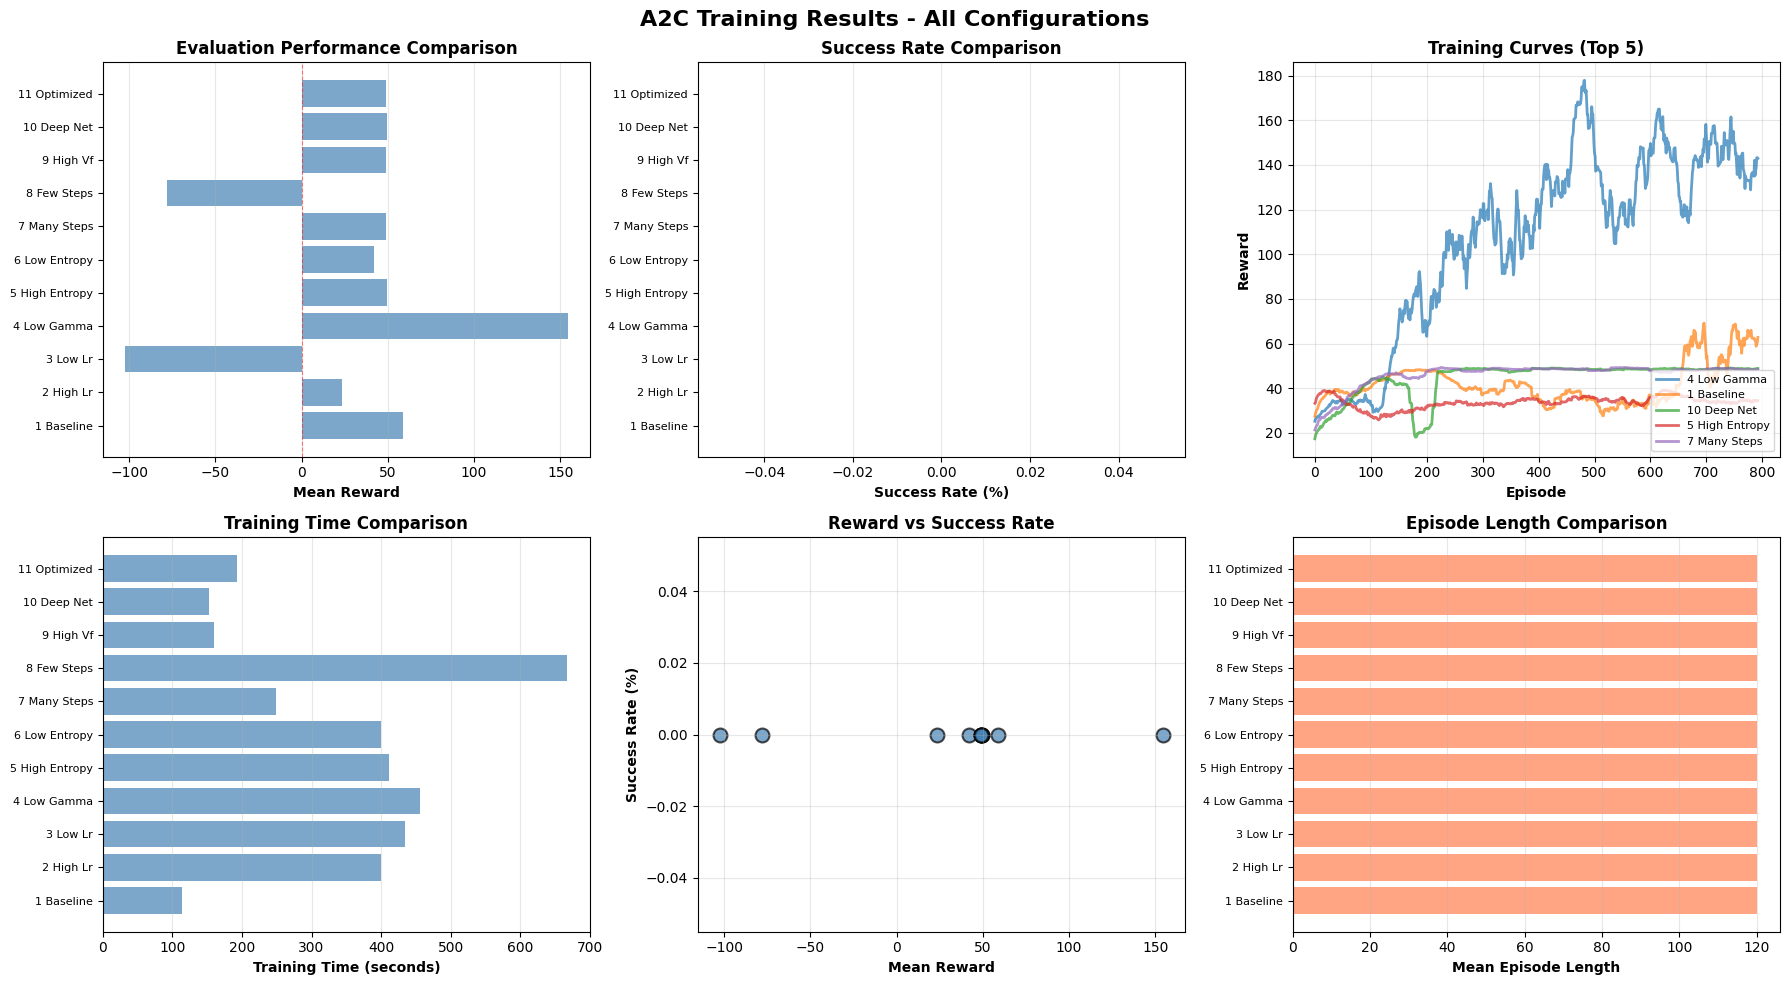

✓ Overall training visualizations complete



In [6]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 5: OVERALL TRAINING VISUALIZATIONS (ALL CONFIGURATIONS)
# ═══════════════════════════════════════════════════════════════════════════

print(f"\n{'='*120}")
print("VISUALIZING OVERALL TRAINING RESULTS")
print(f"{'='*120}\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('A2C Training Results - All Configurations', fontsize=16, fontweight='bold')

# 1. Mean Evaluation Rewards (Bar Chart)
ax = axes[0, 0]
config_names = list(results.keys())
mean_rewards = [results[c]['eval_results']['mean_reward'] for c in config_names]
colors = ['steelblue' for _ in config_names]

bars = ax.barh(range(len(config_names)), mean_rewards, color=colors, alpha=0.7)
ax.set_yticks(range(len(config_names)))
ax.set_yticklabels([c.replace('config_', '').replace('_', ' ').title() 
                     for c in config_names], fontsize=8)
ax.set_xlabel('Mean Reward', fontweight='bold')
ax.set_title('Evaluation Performance Comparison', fontweight='bold')
ax.axvline(x=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
ax.grid(axis='x', alpha=0.3)

# 2. Success Rates (Bar Chart)
ax = axes[0, 1]
success_rates = [results[c]['eval_results']['success_rate'] * 100 for c in config_names]
bars = ax.barh(range(len(config_names)), success_rates, color=colors, alpha=0.7)
ax.set_yticks(range(len(config_names)))
ax.set_yticklabels([c.replace('config_', '').replace('_', ' ').title() 
                     for c in config_names], fontsize=8)
ax.set_xlabel('Success Rate (%)', fontweight='bold')
ax.set_title('Success Rate Comparison', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 3. Training Curves (Top 5 configs)
ax = axes[0, 2]
top_5_configs = sorted(results.keys(), 
                       key=lambda k: results[k]['eval_results']['mean_reward'], 
                       reverse=True)[:5]

for config_name in top_5_configs:
    callback = results[config_name]['callback']
    if len(callback.episode_rewards) > 0:
        # Smooth with moving average
        window = max(10, len(callback.episode_rewards) // 20)
        smoothed = np.convolve(callback.episode_rewards, 
                              np.ones(window)/window, mode='valid')
        label = config_name.replace('config_', '').replace('_', ' ').title()
        ax.plot(smoothed, label=label, linewidth=2, alpha=0.7)

ax.set_xlabel('Episode', fontweight='bold')
ax.set_ylabel('Reward', fontweight='bold')
ax.set_title('Training Curves (Top 5)', fontweight='bold')
ax.legend(fontsize=8, loc='lower right')
ax.grid(alpha=0.3)

# 4. Training Time Comparison
ax = axes[1, 0]
train_times = [results[c]['train_time'] for c in config_names]
bars = ax.barh(range(len(config_names)), train_times, color=colors, alpha=0.7)
ax.set_yticks(range(len(config_names)))
ax.set_yticklabels([c.replace('config_', '').replace('_', ' ').title() 
                     for c in config_names], fontsize=8)
ax.set_xlabel('Training Time (seconds)', fontweight='bold')
ax.set_title('Training Time Comparison', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 5. Reward vs Success Rate Scatter
ax = axes[1, 1]
for i, config_name in enumerate(config_names):
    reward = results[config_name]['eval_results']['mean_reward']
    success = results[config_name]['eval_results']['success_rate'] * 100
    ax.scatter(reward, success, color='steelblue', s=100, marker='o', 
              alpha=0.7, edgecolors='black', linewidth=1.5)

ax.set_xlabel('Mean Reward', fontweight='bold')
ax.set_ylabel('Success Rate (%)', fontweight='bold')
ax.set_title('Reward vs Success Rate', fontweight='bold')
ax.grid(alpha=0.3)

# 6. Episode Length Comparison
ax = axes[1, 2]
mean_lengths = [results[c]['eval_results']['mean_length'] for c in config_names]
bars = ax.barh(range(len(config_names)), mean_lengths, color='coral', alpha=0.7)
ax.set_yticks(range(len(config_names)))
ax.set_yticklabels([c.replace('config_', '').replace('_', ' ').title() 
                     for c in config_names], fontsize=8)
ax.set_xlabel('Mean Episode Length', fontweight='bold')
ax.set_title('Episode Length Comparison', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Overall training visualizations complete\n")

In [7]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 6: IDENTIFY AND SAVE BEST MODEL
# ═══════════════════════════════════════════════════════════════════════════

# Find best configuration based on evaluation reward
best_config_name = max(results.keys(), 
                       key=lambda k: results[k]['eval_results']['mean_reward'])
best_result = results[best_config_name]

print(f"\n{'='*120}")
print(f"BEST PERFORMING CONFIGURATION: {best_config_name}")
print(f"{'='*120}")
print(f"Description: {best_result['config']['description']}")
print(f"\nHyperparameters:")
for key, value in best_result['config'].items():
    if key != 'description':
        print(f"  {key}: {value}")
print(f"\nPerformance:")
print(f"  Mean Reward: {best_result['eval_results']['mean_reward']:.2f} ± "
      f"{best_result['eval_results']['std_reward']:.2f}")
print(f"  Success Rate: {best_result['eval_results']['success_rate']*100:.1f}%")
print(f"  Mean Episode Length: {best_result['eval_results']['mean_length']:.1f}")
print(f"  Training Time: {best_result['train_time']:.1f}s")
print(f"{'='*120}\n")

# Save best model
save_dir = Path("../models/a2c/best_model")
save_dir.mkdir(parents=True, exist_ok=True)

best_model = best_result['model']
best_model.save(save_dir / "a2c_best")

# Save configuration and results
with open(save_dir / "config.json", 'w') as f:
    config_to_save = {k: v for k, v in best_result['config'].items() 
                      if k != 'policy_kwargs'}
    config_to_save['policy_kwargs'] = str(best_result['config']['policy_kwargs'])
    json.dump(config_to_save, f, indent=2)

with open(save_dir / "results.json", 'w') as f:
    json.dump({
        'eval_results': best_result['eval_results'],
        'train_time': best_result['train_time']
    }, f, indent=2)

print(f"Best model saved to: {save_dir}")
print(f"  - Model: a2c_best.zip")
print(f"  - Config: config.json")
print(f"  - Results: results.json\n")


BEST PERFORMING CONFIGURATION: config_4_low_gamma
Description: Low Gamma - Myopic policy

Hyperparameters:
  learning_rate: 0.0007
  gamma: 0.95
  n_steps: 5
  ent_coef: 0.01
  vf_coef: 0.5
  gae_lambda: 0.95
  max_grad_norm: 0.5
  policy_kwargs: {'net_arch': [64, 64], 'optimizer_class': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e-05, 'weight_decay': 0}}

Performance:
  Mean Reward: 154.37 ± 101.35
  Success Rate: 0.0%
  Mean Episode Length: 120.0
  Training Time: 456.3s

Best model saved to: ..\models\a2c\best_model
  - Model: a2c_best.zip
  - Config: config.json
  - Results: results.json




DETAILED EVALUATION OF BEST MODEL

Episodes: 100
Mean Reward: 135.36 ± 114.21
Min/Max Reward: -114.19 / 226.81
Mean Episode Length: 120.0 ± 0.0
Success Rate: 0.0%

Action Distribution:
  Up: 50 (0.4%)
  Down: 558 (4.7%)
  Left: 0 (0.0%)
  Right: 2112 (17.6%)
  Scan: 9280 (77.3%)
  Pickup/Drop: 0 (0.0%)


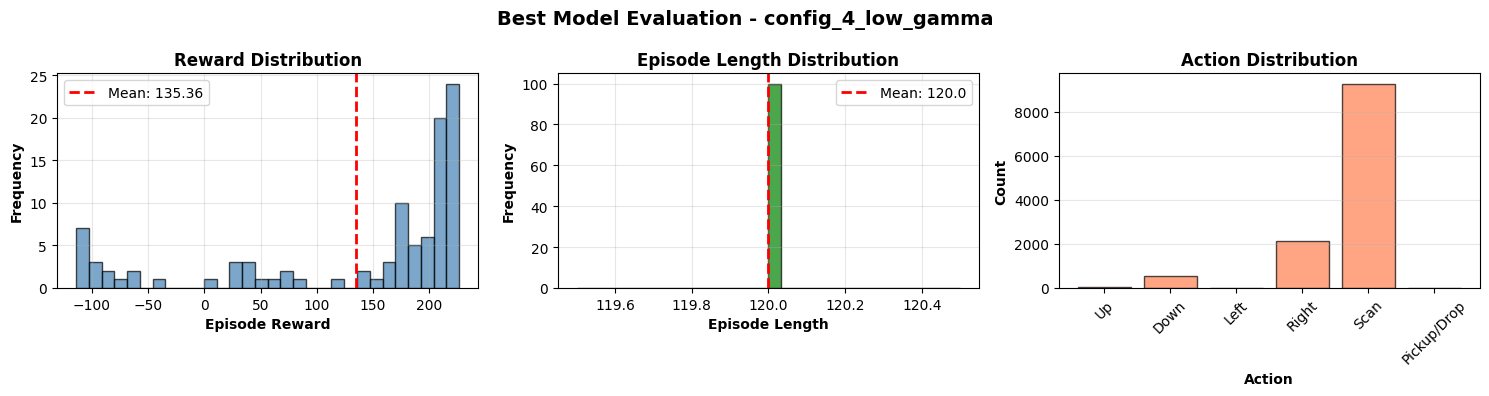


✓ Evaluation completed



In [9]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 7: EVALUATE BEST MODEL
# ═══════════════════════════════════════════════════════════════════════════

print(f"\n{'='*120}")
print("DETAILED EVALUATION OF BEST MODEL")
print(f"{'='*120}\n")

# Run detailed evaluation
env = FireRescueEnv()
n_eval_episodes = 100

episode_rewards = []
episode_lengths = []
successes = 0
actions_taken = []

for ep in range(n_eval_episodes):
    obs, _ = env.reset()
    done = False
    episode_reward = 0
    episode_length = 0
    episode_actions = []
    
    while not done:
        action, _ = best_model.predict(obs, deterministic=True)
        episode_actions.append(action)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
        
        if info.get('success', False):
            successes += 1
    
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
    actions_taken.extend(episode_actions)

# Statistics
print(f"Episodes: {n_eval_episodes}")
print(f"Mean Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
print(f"Min/Max Reward: {np.min(episode_rewards):.2f} / {np.max(episode_rewards):.2f}")
print(f"Mean Episode Length: {np.mean(episode_lengths):.1f} ± {np.std(episode_lengths):.1f}")
print(f"Success Rate: {successes/n_eval_episodes*100:.1f}%")
print(f"\nAction Distribution:")
action_names = ['Up', 'Down', 'Left', 'Right', 'Scan', 'Pickup/Drop']
for i, name in enumerate(action_names):
    count = actions_taken.count(i)
    percentage = count / len(actions_taken) * 100 if actions_taken else 0
    print(f"  {name}: {count} ({percentage:.1f}%)")

env.close()

# Create evaluation visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f'Best Model Evaluation - {best_config_name}', 
            fontsize=14, fontweight='bold')

# Reward distribution
axes[0].hist(episode_rewards, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(episode_rewards), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {np.mean(episode_rewards):.2f}')
axes[0].set_xlabel('Episode Reward', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Reward Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Episode length distribution
axes[1].hist(episode_lengths, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(episode_lengths), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {np.mean(episode_lengths):.1f}')
axes[1].set_xlabel('Episode Length', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title('Episode Length Distribution', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Action distribution
action_counts = [actions_taken.count(i) for i in range(6)]
axes[2].bar(action_names, action_counts, color='coral', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Action', fontweight='bold')
axes[2].set_ylabel('Count', fontweight='bold')
axes[2].set_title('Action Distribution', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Evaluation completed")
print(f"{'='*120}\n")
